In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

Tc = 2.26926
line_symbols = ["-o", "-*", "-v", "-p", "-D"]
marker_symbols = ["o", "*", "v", "p", "D"]

In [6]:
plt.rcParams.update({'font.size':14})

Magnetization

In [13]:
dfs = []
for file in os.listdir("data_summary"):
    if "tri" in file:
        continue
    
    fullpath = os.path.join("data_summary", file)
    with open(fullpath, "r") as f:
        lines = f.readlines()
        if len(lines) == 0:
            continue

        data = lines[0].split(sep=" ")
        if len(data) % 2 != 0:
            continue

        columns = data[::2]
        values = data[1::2]
        data = {column: [float(value)] for column,value in zip(columns, values)}

        for row in lines[1:]:
            row = row.split(sep=" ")
            columns = row[::2]
            values = row[1::2]
            for column, value in zip(columns, values):
                data[column].append(float(value))

        df = pd.DataFrame.from_dict(data)
        df = df.drop(df[np.abs(df["L"]*(df["T"]-Tc)) > 1.0].index)
        df = df.drop(df[df["L"] > 256.0].index)
        df = df.sort_values(by=['T'])
        df = df.reset_index(drop=True)
        if df.empty:
           continue 
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

Text(0, 0.5, 'm')

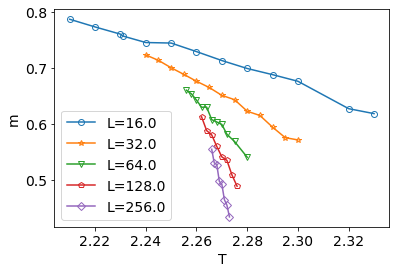

In [17]:
# m vs T
fig, ax = plt.subplots()
for df, line_sym in zip(dfs, line_symbols):
    m = df["m"]
    L = df["L"].iloc[0]
    T = df["T"]

    ax.plot(T, m, line_sym, label=f"L={L}", fillstyle="none")
ax.legend()
ax.set_xlabel("T")
ax.set_ylabel("m")

Text(0, 0.5, '$mL^{\\beta/v}$')

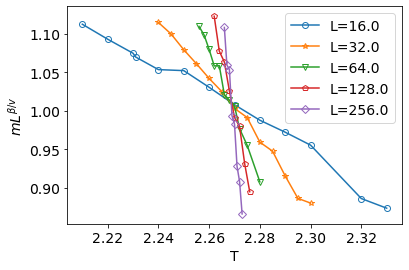

In [18]:
# mL^{beta/v} vs T
beta = 1.0/8.0
v = 1
fig, ax = plt.subplots(1,1)
for df, line_sym in zip(dfs, line_symbols):
    m = df["m"]
    L = df["L"]
    T = df["T"]

    ax.plot(T, m*np.power(L, beta/v), line_sym, label=f"L={L.iloc[0]}", fillstyle="none")
ax.legend()
ax.set_xlabel("T")
ax.set_ylabel(r"$mL^{\beta/v}$")

(-0.25, 0.25)

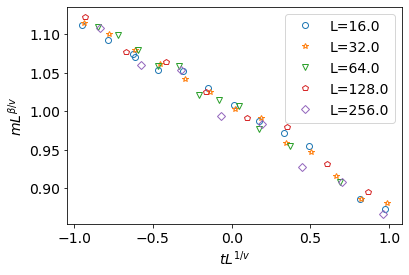

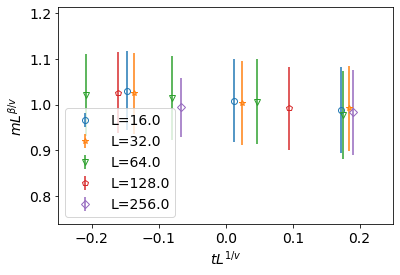

In [27]:
# mL^beta/v vs tL^1/v
fig, ax = plt.subplots(1,1)
fig2, ax2 = plt.subplots(1,1)
for df, sym in zip(dfs, marker_symbols):
    m = df["m"]
    m_var = df["m_variance"]
    L = df["L"]
    T = df["T"]

    t = T - Tc

    L_beta_v = np.power(L, beta/v)
    y_err = np.sqrt(m_var*L_beta_v*L_beta_v)

    xval = t*np.power(L, 1.0/v)
    yval = m*np.power(L, beta/v)
    ax.plot(xval, yval, sym, label=f"L={L.iloc[0]}", fillstyle="none")
    ax2.errorbar(xval, yval, yerr=y_err, label=f"L={L.iloc[0]}", marker=sym, linestyle='', fillstyle="none")
ax.legend()
ax.set_xlabel("$tL^{1/v}$")
ax.set_ylabel(r"$mL^{\beta/v}$")
ax2.set_xlabel("$tL^{1/v}$")
ax2.set_ylabel(r"$mL^{\beta/v}$")
ax2.legend()

ax2.set_xlim([-0.25, 0.25])

# Binder's Cumulant

Text(0, 0.5, 'Q')

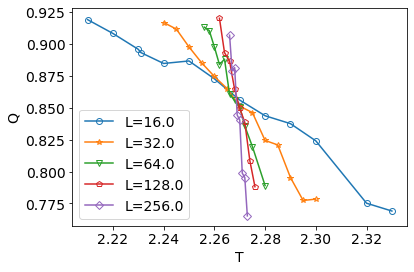

In [28]:
# Q vs T
fig, ax = plt.subplots(1,1)
for df, line_sym in zip(dfs, line_symbols):
    Q = df["Q"]
    L = df["L"]
    T = df["T"]

    ax.plot(T, Q, line_sym, label=f"L={L.iloc[0]}", fillstyle="none")
ax.legend()
ax.set_xlabel("T")
ax.set_ylabel("Q")

Text(0, 0.5, 'Q')

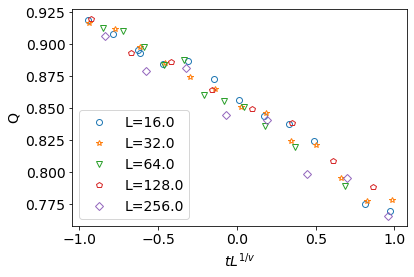

In [29]:
# Q vs tL^{1/v}
fig, ax = plt.subplots(1,1)
for df, marker_sym in zip(dfs, marker_symbols):
    Q = df["Q"]
    L = df["L"]
    T = df["T"]
    t = T-Tc

    xvals = t*np.power(L, 1.0/v)

    ax.plot(xvals, Q, marker_sym, label=f"L={L.iloc[0]}", fillstyle="none")
ax.legend()
ax.set_xlabel("$tL^{1/v}$")
ax.set_ylabel("Q")

# Correlations

In [30]:
corrs = {}
for file in os.listdir("spincorr"):
    fullpath = os.path.join("spincorr", file)
    with open(fullpath, "r") as f:
        lines = f.readlines()
        if len(lines) == 0:
            continue

        header = lines[0].split(sep=" ")
        if len(header) % 2 != 0:
            continue

        header_values = header[1::2]
        L = header_values[0]
        T = header_values[1]

        if L not in corrs:
            corrs[L] = {}

        data = {"x": [], "value": []}
        for row in lines[2:]:
            row = row.split(sep=" ")
            x_val = int(row[1])
            g_val = float(row[3])
            data["x"].append(x_val)
            data["value"].append(g_val)

        df = pd.DataFrame.from_dict(data)
        corrs[L][T] = df

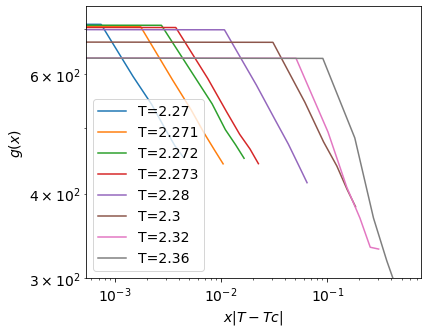

In [46]:
# T > T_c
# log(g) vs x/epsi

correlations = corrs["256"]
epsilons = {"T": [], "time": []}

fig, ax = plt.subplots()
fig.set_size_inches((6, 5))
for T_key in correlations:
    T = float(T_key)
    if T <= Tc:
        continue
    x = correlations[T_key]["x"]
    n = len(x)
    cutoff = int(0.03*n)
    corr_val = correlations[T_key]["value"]
    x_over_epsi = x*(T - Tc)

    ax.plot(x_over_epsi[:cutoff], corr_val[:cutoff], label=f"T={T}")

    epsi = 1.0/(T-Tc)
    epsilons["T"].append(T)
    epsilons["time"].append(epsi)
    
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$x\|T-Tc\|$")
ax.set_ylabel("$g(x)$")
#ax.set_xlim([0.001, 10**(-0.5)])
ax.set_ylim([3*10**2, 6*10**2.1])
ax.legend()


Text(0, 0.5, 'g(x)')

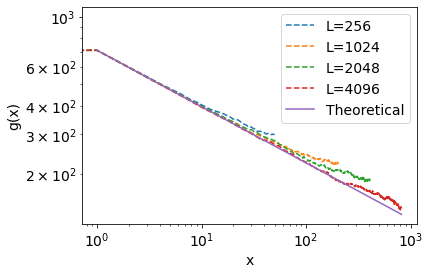

In [50]:
# T = Tc
fig, ax = plt.subplots()
for L in ["256", "1024", "2048", "4096"]:
    for T_key in corrs[L]:
        T = float(T_key)
        if np.abs(T - Tc) < 0.00001:
            data = corrs[L][T_key]
            
            x = data["x"]
            val = data["value"]

            n = len(x)
            cutoff = int(0.2 * n)
            
            ax.plot(x[:cutoff], val[:cutoff], '--', label=f"L={L}")

# Also plot analytical
# for d = 2, eta =1/4
eta = 1/4
ax.plot(x[:cutoff], x[:cutoff]**(-eta)*val[1], label="Theoretical")

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("g(x)")

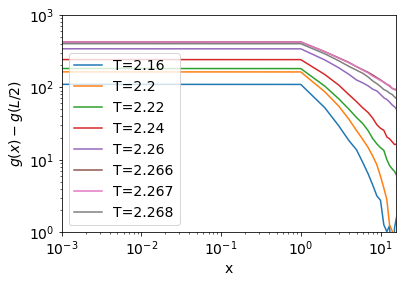

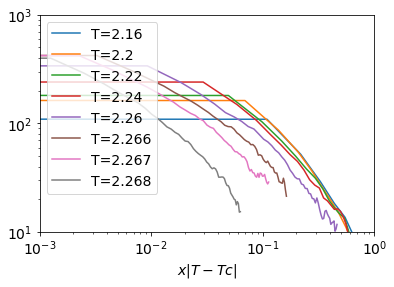

In [54]:
#T < Tc

correlations = corrs["256"]

fig, ax = plt.subplots()
fig1, ax1 = plt.subplots()

for T_key in correlations:
    T = float(T_key)
    if T >= Tc:
        continue
    x = correlations[T_key]["x"]
    n = len(x)
    cutoff = int(0.2*n)
    g = correlations[T_key]["value"]

    g_offset = g[127]

    x = x[:cutoff]
    x_over_epsi = x*(Tc-T)
    g = g[:cutoff] - g_offset

    ax.plot(x, g, label=f"T={T}")
    ax1.plot(x_over_epsi, g, label=f"T={T}")

    epsi = 1.0/(Tc - T)
    epsilons["T"].append(T)
    epsilons["time"].append(epsi)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([0.001, 10**1.2])
ax.set_ylim([10**0, 10**3])
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("$g(x) - g(L/2)$")

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlim([0.001, 10**(0)])
ax1.set_ylim([10**1, 10**3])
ax1.set_xlabel("$x\|T-Tc\|$")
ax.set_ylabel("$g(x) - g(L/2)$")
ax1.legend()

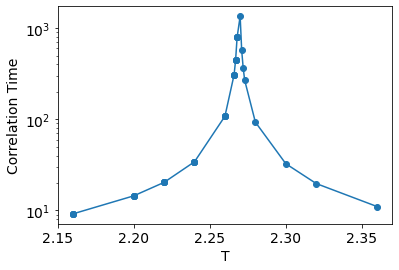

In [56]:
epsilon_df = df.from_dict(epsilons)
epsilon_df = epsilon_df.sort_values(by=['T'])
# epsilon vs T
fig, ax = plt.subplots()

ax.plot(epsilon_df["T"], epsilon_df["time"], '-o')

ax.set_xlabel("T")
ax.set_ylabel("Correlation Time")
ax.set_yscale("log")

# Triangular Lattice

In [59]:
dfs = []
for file in os.listdir("data_summary"):
    if "tri" not in file:
        continue
    
    fullpath = os.path.join("data_summary", file)
    with open(fullpath, "r") as f:
        lines = f.readlines()
        if len(lines) == 0:
            continue

        data = lines[0].split(sep=" ")
        if len(data) % 2 != 0:
            continue

        columns = data[::2]
        values = data[1::2]
        data = {column: [float(value)] for column,value in zip(columns, values)}

        for row in lines[1:]:
            row = row.split(sep=" ")
            columns = row[::2]
            values = row[1::2]
            for column, value in zip(columns, values):
                data[column].append(float(value))

        df = pd.DataFrame.from_dict(data)
        df = df.sort_values(by=['T'])
        if df.empty:
           continue 
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

Text(0, 0.5, 'm')

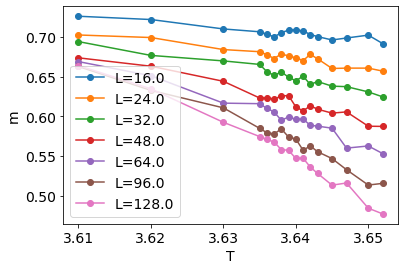

In [60]:
# m vs T
fig, ax = plt.subplots()
for df_i in dfs:
    m = df_i["m"]
    L = df_i["L"].iloc[0]
    T = df_i["T"]

    ax.plot(T, m, '-o', label=f"L={L}")

ax.legend()
ax.set_xlabel("T")
ax.set_ylabel("m")
    

Text(0, 0.5, 'Q')

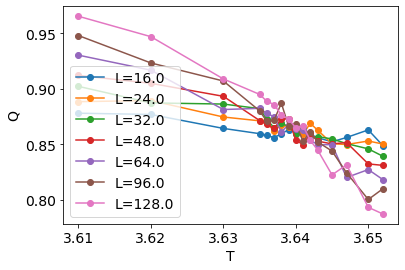

In [73]:
# Binders Cumulant
fig, ax = plt.subplots(1,1)
for df_i in dfs:
    Q = df_i["Q"]
    L = df_i["L"]
    T = df_i["T"]

    ax.plot(T, Q, '-o', label=f"L={L.iloc[0]}")
ax.legend()
ax.set_xlim([3.638, 3.65])
ax.set_xlabel("T")
ax.set_ylabel("Q")

Estimated Tc for triangular lattice: 3.640929833487527, std. dev: 0.0017719055924668332


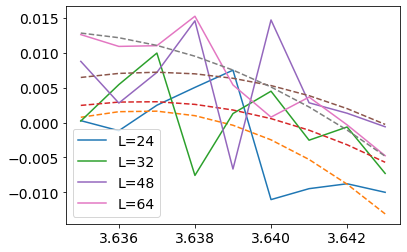

In [71]:
f_dict = {"T": [], "L": [], "value": []}
for df_i in dfs[0:5]:
    Q = df_i["Q"]
    T = df_i["T"]
    L = df_i["L"]

    df_2L = df[df["L"] == L.iloc[0] * 2]
    Q_2 = df_2L["Q"]
    fs = Q_2.reset_index(drop=True) - Q.reset_index(drop=True)
    for T, L, f, in zip(T, L, fs):
        f_dict["T"].append(T)
        f_dict["L"].append(L)
        f_dict["value"].append(f)

f = pd.DataFrame.from_dict(f_dict)

fig, ax = plt.subplots()

Ls = [24, 32, 48, 64]

Tc_tris = []

for L in Ls:
    f_L = f[f["L"] == L]
    f_L = f_L[f_L["T"] > 3.63]
    f_L = f_L[f_L["T"] < 3.645]

    T = f_L["T"]
    f_value = f_L["value"]

    coef = np.polyfit(T, f_value, 2)
    D = coef[1]**2 - 4*coef[0]*coef[2]
    Tc_tri = 1.0/(2.0 * coef[0]) * (-coef[1] - np.sqrt(D))
    Tc_tris.append(Tc_tri)

    ax.plot(T, f_value, label=f"L={L}")
    ax.plot(T, coef[0]*T**2 + coef[1]*T + coef[2], '--')

ax.legend()

Tc_tri = np.mean(Tc_tris)
Tc_tri_vari = np.var(Tc_tris, ddof=1)
print(f"Estimated Tc for triangular lattice: {Tc_tri}, std. dev: {np.sqrt(Tc_tri_vari)}")


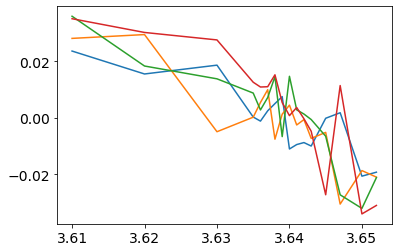

In [72]:
fig, ax = plt.subplots()
for L in Ls:
    f_L = f[f["L"] == L]

    T = f_L["T"]
    f_value = f_L["value"]

    ax.plot(T, f_value, label=f"L={L}")